In [1]:
# !apt update
# !apt-get install git-lfs
# !git lfs install
# !pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
# !pip install -r requirements.txt

In [1]:
import sys
import os
relative_path = os.path.join('.', 'vto_core_module')
sys.path.append(relative_path)

from dotenv import load_dotenv
load_dotenv()

def pi(img_like):
    # Create a figure
    fig, ax = plt.subplots()
    
    ax.imshow(img_like)
    ax.legend()
    plt.savefig('tmp_plot.png')
        
    img = Image.open('tmp_plot.png')

    plt.close(fig)

    return img

def create_sbs_view(*images):
    """
    Create a horizontal stack of the given images after resizing all to match the first image.
    
    Parameters:
    images (list of PIL.Image): List of images to be arranged horizontally.

    Returns:
    PIL.Image: Combined image in a horizontal stack.
    """
    if not images:
        raise ValueError("The list of images is empty.")
    
    # Get the size of the first image
    width, height = images[0].size
    
    # Resize all images to match the first image's size
    resized_images = [img.resize((width, height)) for img in images]
    
    # Calculate the width of the combined image
    total_width = width * len(resized_images)
    
    # Create a new image with the appropriate size
    combined_image = Image.new('RGB', (total_width, height))
    
    # Paste each image in the correct position
    for idx, img in enumerate(resized_images):
        combined_image.paste(img, (idx * width, 0))
    
    return combined_image

def blend_image_with_color(image, mask, color=(0,255,0)):
    # Convert the mask and image to NumPy arrays
    mask_array = np.array(mask)  # Normalize mask to [0, 1]
    image_array = np.array(image)

    # Create a color array (same size as the image, filled with the target color)
    color_array = np.full_like(image_array, color)

    mask_ex = mask_array[..., None].astype(float) * 0.5

    # Blend the image and the color based on the mask
    blended_array = image_array * (1 - mask_ex) + color_array * mask_ex

    # Convert the result back to a PIL Image
    blended_image = Image.fromarray(np.uint8(blended_array))

    return blended_image

def create_image_grid(images, num_columns, num_rows):
    """
    Create a grid image from a list of images.

    Args:
        images (List[Image.Image]): List of PIL Images (must be same size).
        num_columns (int): Number of columns in the grid.
        num_rows (int): Number of rows in the grid.

    Returns:
        Image.Image: The combined grid image.

    Raises:
        ValueError: If no images are provided or the number of images does not match grid dimensions.
    """
    if not images:
        raise ValueError("No images provided.")

    if len(images) != num_columns * num_rows:
        raise ValueError("Number of images does not match grid dimensions.")

    # Assuming all images are the same size
    img_width, img_height = images[0].size

    # Create a new blank image with the appropriate size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    # Paste images into grid
    for idx, img in enumerate(images):
        row = idx // num_columns
        col = idx % num_columns
        x = col * img_width
        y = row * img_height
        grid_image.paste(img, (x, y))

    return grid_image

import sys
import yaml
from pipeline_loader import PipelineLoader

with open('../config/pipeline_config.yaml', 'r') as file:
    pipeline_config = yaml.safe_load(file)

pipeline_loader = PipelineLoader(
    config=pipeline_config,
)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/pyt

Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

In [92]:
%%writefile request_processor.py
import cv2
import torch
import numpy as np
import requests
from io import BytesIO
import yaml
from PIL import Image, ImageChops, ImageFilter

from misc.utils_mask import get_mask_location, erode_mask, remove_small_clusters_np, erode_based_on_distance
from torchvision import transforms
from detectron2.data.detection_utils import convert_PIL_to_numpy,_apply_exif_orientation
from torchvision.transforms.functional import to_pil_image
from misc.segmentation_processor import request_segmentation_results, extract_submask, get_all_submasks, join_submasks
import vto_core_module.apply_net as apply_net
from misc.hands_mask_extender import expand_arms_compose_masking


def pil_image_to_bytes(pil_image, format='PNG'):
    img_byte_arr = BytesIO()
    pil_image.save(img_byte_arr, format=format)
    img_byte_arr.seek(0)
    return img_byte_arr

def correct_masking(preserve_mask, org_image, mask, mask_gray):
    preserve_mask = Image.fromarray(preserve_mask).convert('L')
    mask2_inverted = ImageChops.invert(preserve_mask)
    corrected_mask = ImageChops.multiply(mask, mask2_inverted)
    corrected_mask_gray = Image.composite(org_image, mask_gray, preserve_mask)
    return corrected_mask, corrected_mask_gray


def add_gaussian_noise(image, mean=30, stddev=10):
    # Convert PIL Image to NumPy array
    img_array = np.array(image).astype(int)

    # Generate Gaussian noise
    noise = np.random.normal(mean, stddev, img_array.shape).astype(int)

    # Add the noise to the image
    noisy_image_array = img_array + noise

    # Clip the values to be in a valid range (0, 255)
    noisy_image_array = np.clip(noisy_image_array, 0, 255)

    # Convert the NumPy array back to a PIL Image
    noisy_image = Image.fromarray(noisy_image_array.astype(np.uint8))

    return noisy_image


def request_inpainting(
    image, 
    mask, 
    ip_adapter_image, 
    pos_prompt,
    sd_inpainting_config,
):
    # Convert PIL Images to BytesIO streams
    image_stream = pil_image_to_bytes(image)
    mask_stream = pil_image_to_bytes(mask)
    ip_adapter_image_stream = pil_image_to_bytes(ip_adapter_image)
    
    # Prepare the files dictionary
    files = {
        'image': ('image.png', image_stream, 'image/png'),
        'mask': ('mask.png', mask_stream, 'image/png'),
        'ip_adapter_image': ('ip_adapter_image.png', ip_adapter_image_stream, 'image/png'),
    }
    
    # Prepare the form data
    data = {
        'pos_prompt': pos_prompt,
    }

    server_config = sd_inpainting_config['server']
    port = server_config['port']
    host = server_config['host']
    method_name = server_config['method_name']
    
    inpainting_url = f'http://{host}:{port}/{method_name}'
    # Send the POST request to the API
    response = requests.post(inpainting_url, files=files, data=data)
    
    # Check if the request was successful
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
    else:
        raise BrokenPipeError(
            f'Error in stable diffusion inpainting server: {response.status_code}: {response.text}'
        )
    return image
    

class TryOnProcessor:
    def __init__(self, pipeline_config, pipeline_loader):
        self.pipeline_config = pipeline_config
        self.segmentaion_config = self.pipeline_config['segmentaion']
        self.device = pipeline_config['device']
        self.vto_core = pipeline_loader.get_vto_core()
        self.openpose_model = pipeline_loader.get_openpose_model()
        self.parsing_model = pipeline_loader.get_parsing_model()
        self.attribute_classifier = pipeline_loader.get_attributes_classifier()
        self.garment_description_generator = pipeline_loader.get_garment_description_generator()

        self.tensor_transform = self.vto_core.get_tensor_transform()

        with open(pipeline_config['sd_inpainting_config_path'], 'r') as file:
            self.sd_inpainting_config = yaml.safe_load(file)


    def to(self, device):
        self.vto_core.to(device)

    def preprocess_submasks(self, init_image):
        init_segmentation_map, init_classes_mapping = request_segmentation_results(
            url=self.segmentaion_config['service_url'], 
            image=init_image
        )

        pre_preservation_classes = extract_submask(
            segmentation_map=init_segmentation_map,
            submask_classes=self.segmentaion_config['pre_preservation_classes'],
            classes_mapping=init_classes_mapping
        )

        pre_preservation_classes = erode_mask(pre_preservation_classes)

        return pre_preservation_classes, init_segmentation_map, init_classes_mapping
        

    def get_arms_hands_split_masks(self, submasks):
        arms_class_names = self.segmentaion_config['soft_preservation_classes']
        hands_cls = self.segmentaion_config['hands_classes']
        arms_wo_hands_cls = set(arms_class_names) - set(hands_cls)
        
        arms_wo_hands_submask = join_submasks(
            submasks, arms_wo_hands_cls
        )

        hands_submask = join_submasks(
            submasks, hands_cls
        )
        return arms_wo_hands_submask, hands_submask


    def postprocess_submasks(
        self, 
        init_image, 
        init_submasks,
        result_submasks,
        result_image,
        erode_size = 7,
        erosion_size_final=3,
    ):
        arms_wo_hands_init_submask, hands_init_submask = self.get_arms_hands_split_masks(init_submasks)

        upper_clothe_mask = join_submasks(
            init_submasks, ['Upper_Clothing']
        )

        arms_wo_hands_init_submask = erode_based_on_distance(
            arms_wo_hands_init_submask, 
            upper_clothe_mask, 
            threshold = erode_size,
            kernel_size=erode_size,
        )

        soft_preservation_submask = np.logical_or(arms_wo_hands_init_submask, hands_init_submask)

        
        clothing_submask = join_submasks(
            result_submasks, self.segmentaion_config['clothing_classes']
        )

        soft_mask = np.logical_and(
            soft_preservation_submask, 
            np.logical_not(clothing_submask)
        )
        soft_mask = remove_small_clusters_np(soft_mask, min_size=1000)
        soft_mask_pil = Image.fromarray(soft_mask).convert("L")
        soft_mask_pil = erode_mask(soft_mask_pil,erosion_size=erosion_size_final)

        composed_image = Image.composite(init_image, result_image, soft_mask_pil)

        return composed_image
    

    def get_union_mask(self, init_submasks, result_submasks, blur_size=5):
        arms_wo_hands_init_submask, hands_init_submask = self.get_arms_hands_split_masks(init_submasks)
        
        arms_result_submask =  join_submasks(
            result_submasks, self.segmentaion_config['hands_classes']
        )
        
        union_mask = np.logical_or(arms_wo_hands_init_submask, arms_result_submask)
        union_mask = np.logical_and(union_mask, np.logical_not(hands_init_submask))
        union_mask = cv2.dilate(
            union_mask.astype(np.uint8), 
            kernel=np.ones((3, 3), np.uint8),
            iterations=1
        ) 
        union_mask = union_mask > 0
        
        union_mask_pil = Image.fromarray(union_mask).convert('L')
        union_mask_pil = union_mask_pil.filter(ImageFilter.GaussianBlur(blur_size))
        return union_mask_pil


    def get_more_compose_result(self, human_img, init_submasks, result_submasks, keypoints_res, compose_result):
        more_compose_masks = expand_arms_compose_masking(
            human_img,
            init_submasks,
            result_submasks,
            keypoints_res,
            erode_size=10,
        )

        if more_compose_masks is None:
            return compose_result
        
        more_compose_masks_pil = Image.fromarray(more_compose_masks)
        more_compose_masks_pil = more_compose_masks_pil.convert('L')
        more_compose_result = Image.composite(human_img, compose_result, more_compose_masks_pil)
    
        return more_compose_result

    def preprocess_images(self, human_canva, garm_img):
        garm_img = garm_img.convert("RGB").resize((768, 1024))
        human_img_orig = human_canva["background"].convert("RGB")
        human_img = human_img_orig.resize((768, 1024))
        return garm_img, human_img, human_img_orig

    def generate_keypoints_and_parse_model(self, human_img):
        resized_human_img = human_img.resize((384, 512))
        keypoints = self.openpose_model(resized_human_img)
        model_parse, _, parsing_result = self.parsing_model(resized_human_img)
        return keypoints, model_parse, parsing_result

    def generate_mask_and_mask_gray(self, model_parse, keypoints, human_img):
        mask, mask_gray = get_mask_location('hd', "upper_body", model_parse, keypoints)
        mask = mask.resize((768, 1024))
        mask_gray = (1 - transforms.ToTensor()(mask)) * self.tensor_transform(human_img)
        mask_gray = to_pil_image((mask_gray + 1.0) / 2.0)
        return mask, mask_gray

    def prepare_human_image_for_pose_estimation(self, human_img):
        human_img_arg = _apply_exif_orientation(human_img.resize((384, 512)))
        human_img_arg = convert_PIL_to_numpy(human_img_arg, format="BGR")
        return human_img_arg

    def generate_pose_image(self, human_img_arg):
        argument_parser = apply_net.create_argument_parser()
        args = argument_parser.parse_args(
            (
                'show',
                './configs/densepose_rcnn_R_50_FPN_s1x.yaml',
                './ckpt/densepose/model_final_162be9.pkl',
                'dp_segm', '-v', '--opts', 'MODEL.DEVICE', self.device
            )
        )
        pose_img = args.func(args, human_img_arg)
        pose_img = pose_img[:, :, ::-1]
        pose_img = Image.fromarray(pose_img).resize((768, 1024))
        return pose_img

    def process_tryon(
        self, human_canva, garm_img, garment_des=None, denoise_steps=50, seed=997
    ):
        if garment_des is None:
            garment_des = self.garment_description_generator.get_description(garm_img)
        # Preprocess images
        garm_img, human_img, human_img_orig = self.preprocess_images(human_canva, garm_img)
        org_size = human_img_orig.size

        attributes = self.attribute_classifier.forward(human_img)
        
        (
            pre_preservation_classes,
            init_segmentation_map,
            init_classes_mapping
        ) = self.preprocess_submasks(init_image=human_img)
        
        # Generate keypoints and parse model
        keypoints, model_parse = self.generate_keypoints_and_parse_model(human_img)
        
        # Generate mask and mask_gray
        mask, mask_gray = self.generate_mask_and_mask_gray(model_parse, keypoints, human_img)
        
        mask, mask_gray = correct_masking(
            preserve_mask=pre_preservation_classes, 
            org_image=human_img,
            mask=mask,
            mask_gray=mask_gray
        )
        
        # Prepare human image for pose estimation
        human_img_arg = self.prepare_human_image_for_pose_estimation(human_img)
        
        # Generate pose image
        pose_img = self.generate_pose_image(human_img_arg)

        result_image = self.vto_core.process_vto_pipeline(
            pose_img,
            garm_img,
            human_img,
            garment_des,
            mask,
            denoise_steps,
            seed,
            attributes=attributes
        )
        
        
        result_image_noised = add_gaussian_noise(result_image, mean=30, stddev=10)
        result_segmentation_map, result_classes_mapping = request_segmentation_results(
            url=self.segmentaion_config['service_url'], 
            image=result_image_noised
        )
        
        init_submasks = get_all_submasks(
            segmentation_map=init_segmentation_map,
            classes_mapping=init_classes_mapping
        )
        
        result_submasks = get_all_submasks(
            segmentation_map=result_segmentation_map,
            classes_mapping=result_classes_mapping
        )

        compose_result = self.postprocess_submasks(
            init_image=human_img,
            init_submasks=init_submasks,
            result_submasks=result_submasks,
            result_image=result_image,
        )
        
        keypoints_res, _ = self.generate_keypoints_and_parse_model(result_image)
        
        more_compose_result = self.get_more_compose_result(
            human_img, 
            init_submasks, 
            result_submasks,
            keypoints_res, 
            compose_result
        )
        
        union_mask_pil = self.get_union_mask(
            init_submasks,
            result_submasks
        )

        attributes['garment_des'] = garment_des
        positive_prompt = self.pipeline_config["core_config"]["prompt"].format(**attributes)
        
        inpainting_result = request_inpainting(
            image=more_compose_result,
            mask=union_mask_pil,
            ip_adapter_image=human_img,
            pos_prompt=positive_prompt,
            sd_inpainting_config=self.sd_inpainting_config
        )

        inpainting_result_res = inpainting_result.resize(org_size)
        result_image_res = result_image.resize(org_size)
        
        return inpainting_result_res, result_image_res

Overwriting request_processor.py


In [6]:
# Define your paths
from pathlib import Path
img_folder = '/workspace/VTO_demo/example/human_small/'  # Folder containing images
garm_folder = Path('/workspace/VTO_demo/example/cloth_small/')
output_folder = '/workspace/VTO_demo/example/output_small/'
denoise_steps = 50
seed = 997
demo_size = (512,512)
device = 'cuda'

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open('sd_inpainting_module/config.yaml', 'r') as file:
    sd_inpainting_config = yaml.safe_load(file)

In [7]:
tryon = TryOnProcessor(
    pipeline_config, pipeline_loader
)

In [26]:
humans = [Image.new('RGB', demo_size, 'white')]
for img_name in os.listdir(img_folder):
    img_path = os.path.join(img_folder, img_name)
    
    if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    human = Image.open(img_path).convert('RGB')
    human = human.resize(demo_size)
    humans.append(human)

In [27]:
final_result_images = humans
result_images = []
garm_images = []
human_images = []
for garm_path in garm_folder.glob('*.jpg'):    
    garm_img = Image.open(str(garm_path))
    garment_des = garm_path.stem
    final_result_images.append(garm_img.resize(demo_size))
    # garment_des = tryon.garment_description_generator.get_description(garm_img)
    for img_name in os.listdir(img_folder):
        img_path = os.path.join(img_folder, img_name)
        
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        human_canva = {'background': Image.open(img_path)}
        
        final_result_image, result_image = tryon.process_tryon(
            human_canva,
            garm_img,
            garment_des,
            denoise_steps,
            seed,
        )
        result_images.append(result_image)
        final_result_images.append(final_result_image)
        # Save the result image
        # output_path = Path(output_folder) / Path(img_name).stem
        # output_path.mkdir(exist_ok=True)
        # output_path_img = output_path / garm_path.name
        # final_result_image.save(output_path_img)
        # print(f'Saved: {output_path_img}')

        garm_images.append(garm_img)
        human_images.append(Image.open(img_path))

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


In [ ]:
# nrow = len(list(garm_folder.glob('*.jpg')))
# ncol = len(os.listdir(img_folder))

# filter_final = [img for img in final_result_images if img.size != (512,512)]

# final_result_images = final_result_images
# result_images = []
# garm_images = []
# human_images = []

# for idx, img_tp in enumerate(zip(human_images, garm_images, filter_final)):
#     grid = create_sbs_view(*img_tp)
#     grid.save(f"triplets_images/triplet_{idx}.jpg")

# nrow = len(list(garm_folder.glob('*.jpg')))
# ncol = len(os.listdir(img_folder))
# grid = create_image_grid(result_images, ncol, nrow)
# grid.save(f'../../tmp/grid_{var}.jpg')

# grid = create_image_grid(final_result_images, ncol+1, nrow+1)
# grid.save(f'../../tmp/grid_inpaint_{var}.jpg')

In [8]:
self = TryOnProcessor(
    pipeline_config, pipeline_loader
)

In [9]:
img_path = '/workspace/VTO_demo/example/human/chad.png'

human_canva = {
    'background': Image.open(
        img_path
)}

garm_path = "/workspace/VTO_demo/example/cloth/Short Sleeve Open Front Kimono in Yellow with Tropical Floral Print.jpg"
garm_img = Image.open(garm_path)
garment_des = Path(garm_path).stem

In [31]:
# garment_des = None

In [19]:
if garment_des is None:
    garment_des = self.garment_description_generator.get_description(garm_img)
# Preprocess images
garm_img, human_img, human_img_orig = self.preprocess_images(human_canva, garm_img)
org_size = human_img_orig.size

attributes = self.attribute_classifier.forward(human_img)

(
    pre_preservation_classes,
    init_segmentation_map,
    init_classes_mapping
) = self.preprocess_submasks(init_image=human_img)

# Generate keypoints and parse model
keypoints, model_parse, parsing_result = self.generate_keypoints_and_parse_model(human_img)

# Generate mask and mask_gray
mask, mask_gray = self.generate_mask_and_mask_gray(model_parse, keypoints, human_img)

mask, mask_gray = correct_masking(
    preserve_mask=pre_preservation_classes, 
    org_image=human_img,
    mask=mask,
    mask_gray=mask_gray
)

# Prepare human image for pose estimation
human_img_arg = self.prepare_human_image_for_pose_estimation(human_img)

# Generate pose image
pose_img = self.generate_pose_image(human_img_arg)

result_image = self.vto_core.process_vto_pipeline(
    pose_img,
    garm_img,
    human_img,
    garment_des,
    mask,
    denoise_steps,
    seed,
    attributes=attributes
)


result_image_noised = add_gaussian_noise(result_image, mean=30, stddev=10)
result_segmentation_map, result_classes_mapping = request_segmentation_results(
    url=self.segmentaion_config['service_url'], 
    image=result_image_noised
)

init_submasks = get_all_submasks(
    segmentation_map=init_segmentation_map,
    classes_mapping=init_classes_mapping
)

result_submasks = get_all_submasks(
    segmentation_map=result_segmentation_map,
    classes_mapping=result_classes_mapping
)

compose_result = self.postprocess_submasks(
    init_image=human_img,
    init_submasks=init_submasks,
    result_submasks=result_submasks,
    result_image=result_image,
)

keypoints_res, _, _ = self.generate_keypoints_and_parse_model(result_image)

more_compose_result = self.get_more_compose_result(
    human_img, 
    init_submasks, 
    result_submasks,
    keypoints_res, 
    compose_result
)

union_mask_pil = self.get_union_mask(
    init_submasks,
    result_submasks
)

attributes['garment_des'] = garment_des
positive_prompt = self.pipeline_config["core_config"]["prompt"].format(**attributes)

inpainting_result = request_inpainting(
    image=more_compose_result,
    mask=union_mask_pil,
    ip_adapter_image=human_img,
    pos_prompt=positive_prompt,
    sd_inpainting_config=self.sd_inpainting_config
)

inpainting_result_resized = inpainting_result.resize(org_size)
result_image_resized = result_image.resize(org_size)

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


In [35]:
mask_gray.save('mask_gray.jpg')

In [38]:
add_gaussian_noise(human_img, mean=50).save("noise.jpg")

In [40]:
pose_img.save('pose.jpg')

In [42]:
result_image.save('result.jpg')

In [33]:
Im(pre_preservation_classes).save('hand.jpg')

In [43]:
result_image_noised.save('noised.jpg')

In [44]:
more_compose_masks = expand_arms_compose_masking(
    human_img,
    init_submasks,
    result_submasks,
    keypoints_res,
    erode_size=10,
)

In [54]:
blend_image_with_color(result_image, more_compose_masks).save('more_compose_result.jpg')

In [53]:
blend_image_with_color(result_image, Im(np.array(soft_mask_pil)>0)).save('composeresult.jpg')

In [56]:
from misc.hands_mask_extender import *

In [58]:
keypoints_result = keypoints

In [59]:
img_resized_size = (384, 512)
keypoints_resized = resize_keypoints_back(keypoints_result['pose_keypoints_2d'], img_resized_size, human_img.size)

points_idxses = {
    'Right_Shoulder' : 2,
    'Right_Elbo' : 3,
    'Right_Hand' : 4,
    'Left_Shoulder': 5,
    'Left_Elbo' : 6,
    'Left_Hand' : 7,
}

keypoints_coords = {}
for name, idx in points_idxses.items():
    keypoints_coords[name] = keypoints_resized[idx]

In [60]:
keypoints_coords

{'Right_Shoulder': [212, 478],
 'Right_Elbo': [124, 758],
 'Right_Hand': [202, 800],
 'Left_Shoulder': [532, 470],
 'Left_Elbo': [618, 784],
 'Left_Hand': [418, 824]}

In [ ]:
def bresenham_line(x1, y1, x2, y2, sizes):
    line_points1 = _bresenham_line(x1, y1, x2, y2, sizes=sizes)
    line_points2 = _bresenham_line(x2, y2, x1, y1, sizes=sizes)
    line_points = list(set(line_points1 + line_points2))
    return line_points

In [78]:
additional_compose_masks = [
    {
        'mask1': result_submasks['Left_Lower_Arm'],
        'mask2': init_submasks['Left_Lower_Arm'] + init_submasks['Apparel'],
        'center1': keypoints_coords['Left_Elbo'],
        'center2': keypoints_coords['Left_Hand'],
    },
    {
        'mask1': result_submasks['Right_Lower_Arm'],
        'mask2': init_submasks['Right_Lower_Arm'] + init_submasks['Apparel'],
        'center1': keypoints_coords['Right_Elbo'],
        'center2': keypoints_coords['Right_Hand'],
    },
    {
        'mask1': result_submasks['Left_Upper_Arm'],
        'mask2': init_submasks['Left_Upper_Arm'],
        'center1': keypoints_coords['Left_Shoulder'],
        'center2': keypoints_coords['Left_Elbo'],
    },
    {
        'mask1': result_submasks['Right_Upper_Arm'],
        'mask2': init_submasks['Right_Upper_Arm'],
        'center1': keypoints_coords['Right_Shoulder'],
        'center2': keypoints_coords['Right_Elbo'],
    }
]

In [75]:
canva = np.array(result_image.copy())

In [79]:
for dct in additional_compose_masks:
    p1 = dct['center1']
    p2 = dct['center2']
    dots = bresenham_line(
        p1[0],
        p1[1],
        p2[0],
        p2[1],
        human_img.size[::-1]
    )
    for dot in dots:
        canva = cv2.circle(canva, (int(dot[0]), int(dot[1])), radius=5, color=(0, 255, 0), thickness=-1)

for val in keypoints_coords.values():
    canva = cv2.circle(canva, (int(val[0]), int(val[1])), radius=10, color=(255, 0, 0), thickness=-1)

In [85]:
blend_image_with_color(Im(canva), more_compose_masks,color=(0,0,255)).save('mask.geom.jpg')

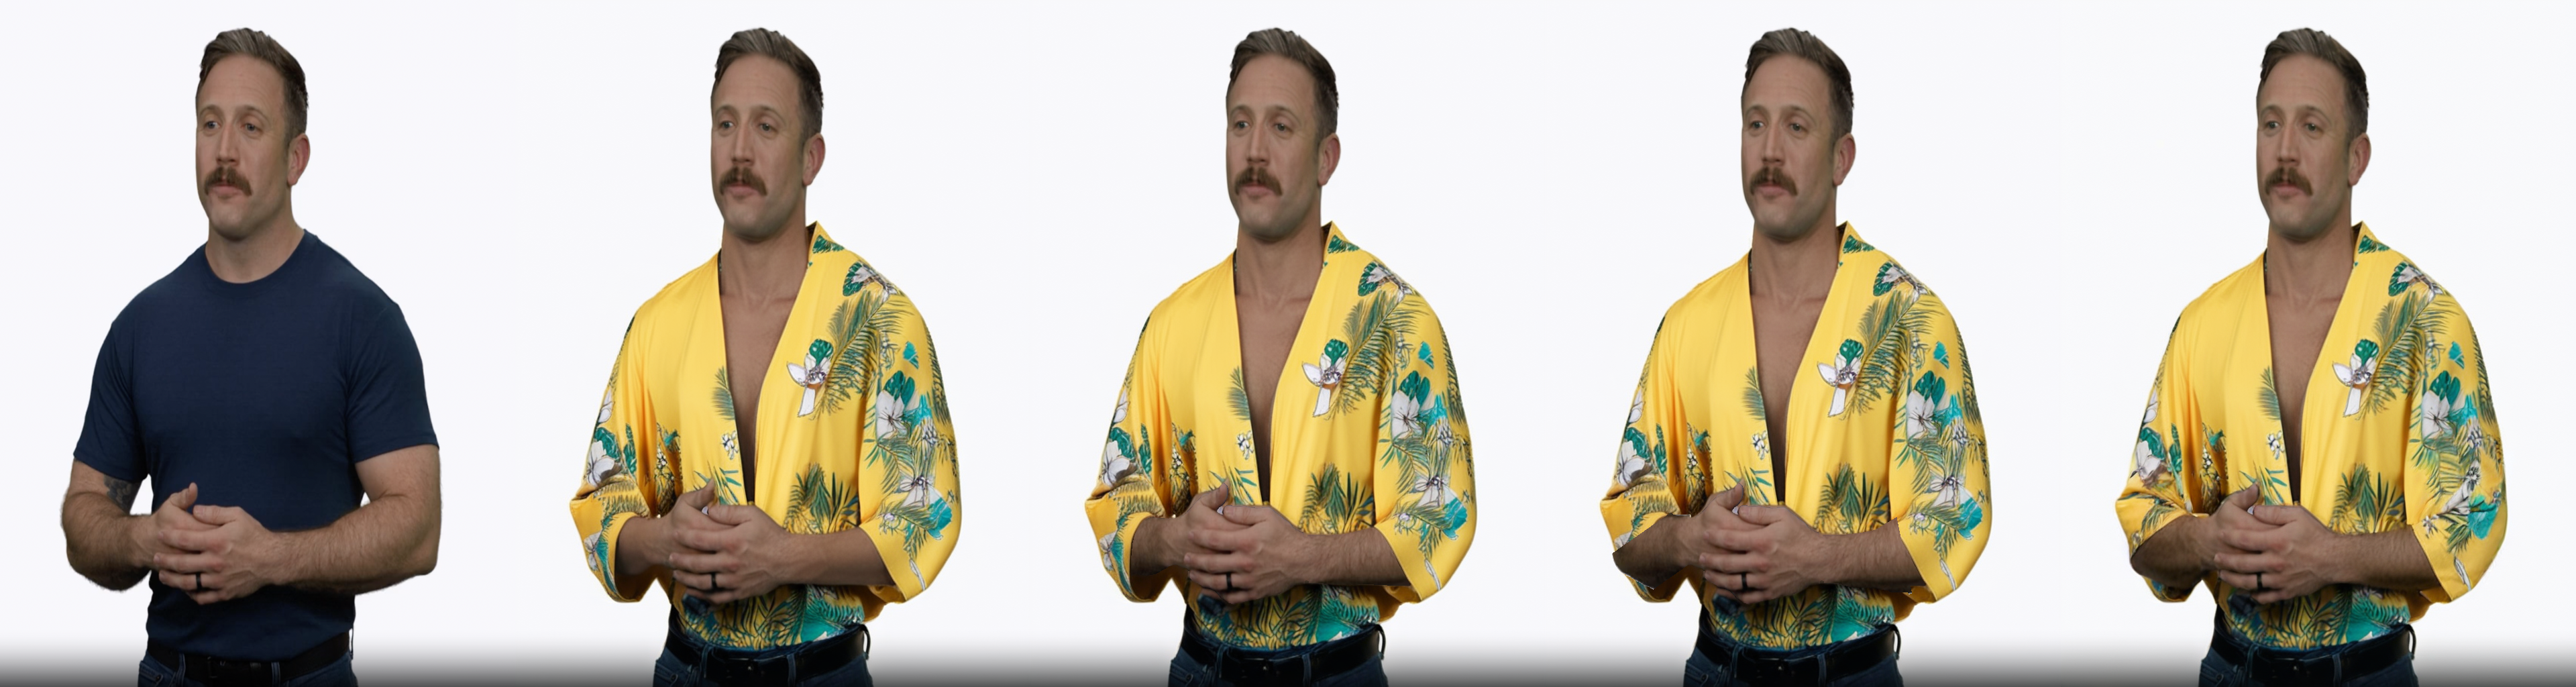

In [33]:
create_sbs_view(human_img, result_image, compose_result, more_compose_result, inpainting_result)

In [91]:
for i in range(25):
    print(f'![teaser](assets/triplet_{i}.jpg)&nbsp;')

![teaser](assets/triplet_0.jpg)&nbsp;
![teaser](assets/triplet_1.jpg)&nbsp;
![teaser](assets/triplet_2.jpg)&nbsp;
![teaser](assets/triplet_3.jpg)&nbsp;
![teaser](assets/triplet_4.jpg)&nbsp;
![teaser](assets/triplet_5.jpg)&nbsp;
![teaser](assets/triplet_6.jpg)&nbsp;
![teaser](assets/triplet_7.jpg)&nbsp;
![teaser](assets/triplet_8.jpg)&nbsp;
![teaser](assets/triplet_9.jpg)&nbsp;
![teaser](assets/triplet_10.jpg)&nbsp;
![teaser](assets/triplet_11.jpg)&nbsp;
![teaser](assets/triplet_12.jpg)&nbsp;
![teaser](assets/triplet_13.jpg)&nbsp;
![teaser](assets/triplet_14.jpg)&nbsp;
![teaser](assets/triplet_15.jpg)&nbsp;
![teaser](assets/triplet_16.jpg)&nbsp;
![teaser](assets/triplet_17.jpg)&nbsp;
![teaser](assets/triplet_18.jpg)&nbsp;
![teaser](assets/triplet_19.jpg)&nbsp;
![teaser](assets/triplet_20.jpg)&nbsp;
![teaser](assets/triplet_21.jpg)&nbsp;
![teaser](assets/triplet_22.jpg)&nbsp;
![teaser](assets/triplet_23.jpg)&nbsp;
![teaser](assets/triplet_24.jpg)&nbsp;


In [90]:
inpainting_result.save('inpainting_result.jpg')

In [89]:
union_mask_pil.save('union_mask_pil.jpg')

In [198]:
fin_segmentation_map, fin_classes_mapping = request_segmentation_results(
    url=self.segmentaion_config['service_url'], 
    image=inpainting_result
)

submsks = get_all_submasks(fin_segmentation_map, fin_classes_mapping)

arms, hands = self.get_arms_hands_split_masks(submsks)
skin = (arms.astype(int) + submsks['Torso']) > 0
init_arms,init_hands = self.get_arms_hands_split_masks(init_submasks)
init_skin = (init_arms + init_submasks['Torso']) > 0
new_skin = (skin.astype(int) - init_skin) > 0
mean_new_color = (np.array(inpainting_result)[new_skin]).mean(0).astype(int)
mean_new_color = tuple(mean_new_color)
new_skin = Image.fromarray(new_skin)

new_skin_image = Image.composite(
    inpainting_result, 
    Image.new('RGB', inpainting_result.size, color=mean_new_color),
    new_skin
)

mean_init_color = (np.array(human_img)[init_skin]).mean(0).astype(int)
mean_init_color = tuple(mean_init_color)

init_skin_image = Image.composite(
    human_img, 
    Image.new('RGB', inpainting_result.size, color=mean_init_color),
    Image.fromarray(init_skin)
)

from color_matcher import ColorMatcher
from color_matcher.normalizer import Normalizer
def correct_color(src_img, ref_img, method):
    src_img = np.array(src_img)
    ref_img = np.array(ref_img)

    cm = ColorMatcher()
    res_img = cm.transfer(src=src_img, ref=ref_img, method=method)
    res_img = Normalizer(res_img).uint8_norm()
    return Image.fromarray(res_img)

res = correct_color(new_skin_image, init_skin_image, 'mvgd')

color_correct_result = Image.composite(res, inpainting_result, new_skin)

Loaded as API: http://127.0.0.1:7860/ ✔


In [ ]:
from preprocess.humanparsing.parsing_api import get_palette

from misc.utils_mask import label_map

mapping = {
    # Mapping original labels to target labels based on semantic similarity
    'Background': target_map['background'],
    'Hair': target_map['hair'],
    'Headset': target_map['hat'],
    # Assuming upper_clothes for torso and general apparel
    'Upper_Clothing': target_map['upper_clothes'],
    # Assuming pants for lower clothing
    'Lower_Clothing': target_map['pants'],
    # Mapping eyeglasses as sunglasses
    ('Eyeglass_Frame', 'Eyeglass_Lenses'): target_map['sunglasses'],
    # Assuming head for face and neck
    ('Face_Neck',): target_map['head'],
    # Mapping shoes and legs
    ('Left_Shoe',): target_map['left_shoe'],
    ('Right_Shoe',): target_map['right_shoe'],
    ('Left_Foot',): target_map['left_leg'],
    ('Right_Foot',): target_map['right_leg'],
    ('Left_Upper_Leg',): target_map['left_leg'],
    ('Right_Upper_Leg',): target_map['right_leg'],
    ('Left_Lower_Leg',): target_map['left_leg'],
    ('Right_Lower_Leg',): target_map['right_leg'],
    ('Left_Upper_Arm',): target_map['left_arm'],
    ('Right_Upper_Arm',): target_map['right_arm']
}

# Creating a final mapping result
final_mapping = {}
for source, value in label_map.items():
    for key, target_value in mapping.items():
        if isinstance(key, tuple) and source in key:
            final_mapping[source] = target_value
        elif source == key:
            final_mapping[source] = target_value

np.unique(parsing_result)

palette = get_palette(19)

palette